### Target: 
- Add Image Augmentation
  - Rotation (around 7 degrees)
  - Translation (around 1.4 pixels)
  - Contrast Jitter (0.04) (To both Train/Test)
- Add LR Scheduler
  - StepLR = 0.07 
  - Momentum = 0.9
  - Step Size = 5 
  - Gamma = 0.1
- Under 8k Parameters
- Under 15 epochs with consistent 99.4 validation cross

### Results:
- Parameters: 7550
- Best Train Accuracy: 98.99
- Best Test Accuracy: 99.53 (12th Epoch)
- Consistent 99.4 validation cross from 6th to 15th epoch

### Analysis:
The model is little under-fitting now. This is fine, as we know we have made our train data harder.

The test accuracy is also up, which means our test data had few images which had transformation difference w.r.t. train dataset.

Good LR schedule is hard to find. Have reduced LR by a factor of 0.1 every 5 epochs. It did help in crossing 99.5 but final accuracy is not more than 99.6.


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.RandomAffine(degrees=7.0, translate=(0.05,0.05), fillcolor=(1,)),
                                       transforms.ColorJitter(contrast=0.04),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), 
                                                                                  # therefore you should add a comma after the values. 
                                                                                  # Note the difference between (0.1307) and (0.1307,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(contrast=0.04),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on


torch.Size([128, 1, 28, 28])
torch.Size([128])
1
2
3
4


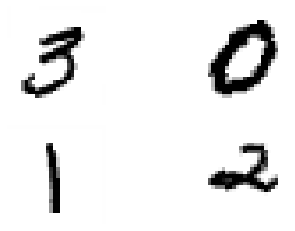

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
%matplotlib inline
import matplotlib.pyplot as plt
figure = plt.figure()
num_of_images = 4
for index in range(1, num_of_images + 1):
    print(index)
    plt.subplot(2, 2, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start enhanching the model we built till now

In [9]:
dropout_value = 0.05

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) 
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) 
        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True)
        ) 
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) 
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3, 3), padding=0, bias=True)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             140
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 18, 24, 24]           2,286
              ReLU-6           [-1, 18, 24, 24]               0
       BatchNorm2d-7           [-1, 18, 24, 24]              36
           Dropout-8           [-1, 18, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,092
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval() # turns off the batchnorm and dropout during testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.17230224609375 Batch_id=468 Accuracy=93.90: 100%|██████████| 469/469 [00:29<00:00, 16.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9838/10000 (98.38%)

EPOCH: 2


Loss=0.01903831772506237 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:29<00:00, 15.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.05637948587536812 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:30<00:00, 15.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.06322839856147766 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:30<00:00, 15.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.08575799316167831 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:29<00:00, 15.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.08441221714019775 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9949/10000 (99.49%)

EPOCH: 7


Loss=0.010702122002840042 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:29<00:00, 15.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9951/10000 (99.51%)

EPOCH: 8


Loss=0.011484677903354168 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


Loss=0.006113772746175528 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 10


Loss=0.032780278474092484 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:30<00:00, 15.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)

EPOCH: 11


Loss=0.03327200189232826 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:29<00:00, 15.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9950/10000 (99.50%)

EPOCH: 12


Loss=0.02521488070487976 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9953/10000 (99.53%)

EPOCH: 13


Loss=0.04118059575557709 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:30<00:00, 15.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

EPOCH: 14


Loss=0.0984182134270668 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.007050860207527876 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:30<00:00, 15.61it/s]



Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

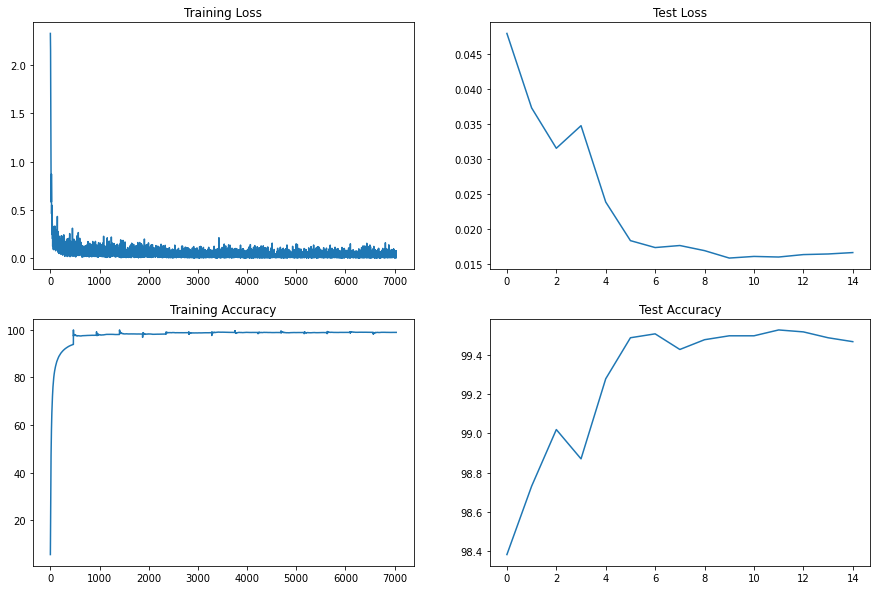

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")